# Module 4: Calculus & Differential Equations

---

# Day 1: Calculus exercises

In a typical calculus course, you'll spend a lot of time doing a bunch of analytical derivatives and integrals by hand of functions that don't necessarily have any real-world meaning. For the purpose of this workshop and this program in general, I don't think it will be very useful to practice calculus for the sake of calculus. For this reason, the following exercises are based on real data where the numerical applications of calculus can be useful. 

Why did we waste all of that time going through analytical applications of calculus? It would be a lie to say that there is absolutely *no* application of analytical methods in neuroscience (e.g. modeling); in fact, we'll see some tomorrow when we introduce differential equations. For this reason, I think it's beneficial to be aware of the analytical methods that exist if you every find yourself in a situation that requires them. But to keep this workshop more rudimentary than comprehensive, we'll just practice the numerical methods here.

In [1]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import numpy.linalg as lin
from scipy.io import loadmat
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

---
## 1. Linearized velocity

I know what you're all thinking: it's been way too long since we played with some of CRE181's data. If you remember back to our example in lecture, we only plotted the CRE181's velocity in the x-dimension. However, since CRE181 is running around in circles, only using the x-dimension will only give half the story. To get the full picture of CRE181's running, we need the velocity in both the x- and y-dimension. One way to do that is to compute both the x-velocity and y-velocity and represent the overall velocity as a vector. However, many analyses become more complicated with additional dimensions. In some situations, like that in an open-field box, there's not much you can do. In other situations, like in our case of a circle track, we can linearize the position into one relevant dimension. Recall the following relationships from trigonometry:

$$
r = \sqrt{x^2 + y^2} \\
\theta = \tan^{-1}\left(\frac{y}{x}\right)
$$

The above equations represent the trasformation from cartesian coordinates ($x$ and $y$) to polar coordinates ($r$ and $\theta$). In polar coordinates, there is only one variable that contains relevant information about the position and velocity, namely $\theta$. If your x- and y-coordinates are centered at the midpoint of the circle track, then $r$ will remain (mostly) constant and only $\theta$ will move according to the position on the circle track.

For the first exercise, we're going to apply this transformation to CRE181's position data to linearize the position and then compute the linearized velocity. First, for this transformation to work, we need to center our x and y coordinates at 0, i.e. put the center of the circle track at (0,0).

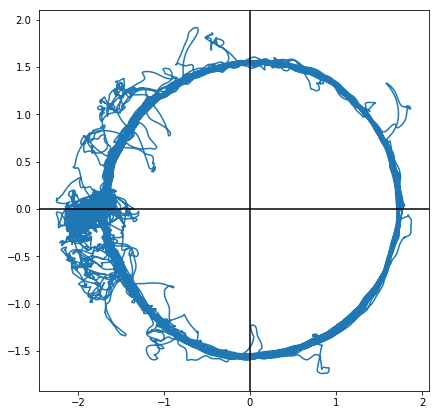

In [2]:
# load data
tmp = loadmat('CRE181_positionData.mat');
data = tmp['data']
ts = data[:,0]
x_orig = data[:,1]/100 # convert to meters
y_orig = data[:,2]/100

# 1. find the offset that will center the coordinates around zero
x_mid = np.mean([0.53,3.97])
y_mid = np.mean([0.18,3.3])

# 2. offset the original coordinates into new ones
x = x_orig-x_mid
y = y_orig-y_mid

# 3. plot to see if it worked!
plt.figure(figsize=(7,7))
plt.plot(x,y);
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.show()

Once we have our circle centered, we can move on to converting the coordinates using the above equations. I suggest using the function ``np.arctan2``, which will give the full range of values between $-\pi$ to $\pi$; however, I would convert this to be from $0$ to $2\pi$ -- we don't want any negative distances! I've also included the helpful function we used in lecture, ``circDiff``, which will help with the cumulative sum if you choose to account for the lap reset. A question to keep in mind: given the radius of the circle track, how might we convert $\theta$ into units of distance?

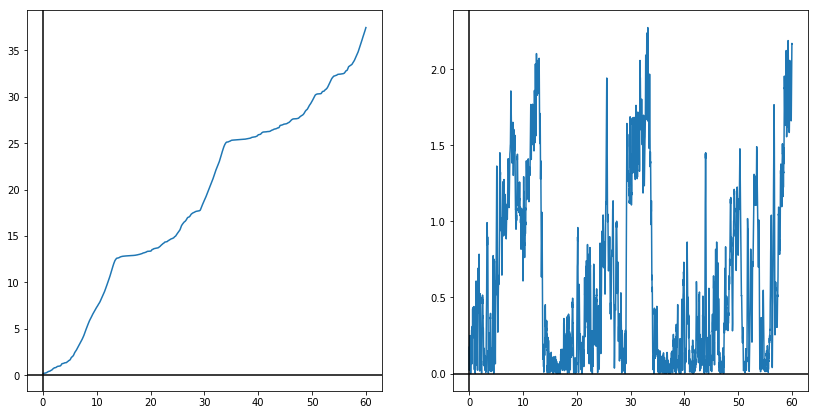

In [3]:
# helpful function
def circDiff(data):
    cycle = 2*np.pi          
    diffData = np.diff(data)
    diffData2 = np.vstack((diffData,diffData+cycle,diffData-cycle))
    return np.min(abs(diffData2),axis=0)

# 1. compute theta as well as the cumulative sum of theta to get a continuous estimate of distance
theta = -1*np.arctan2(y,x) + np.pi  # I flipped this to make CRE181 appear to run clockwise instead of counter-clockwise; this is totally not required
cum_theta = np.cumsum(np.hstack((theta[0],circDiff(theta))))

# 2. using the radius, convert theta into a measure of distance
r = np.sqrt(x**2+y**2)
circumf = 2*np.pi*np.mean(r)
cum_pos = circumf * cum_theta/(2*np.pi)

# 3. compute the velocity as m/s
vel = np.diff(cum_pos)/np.diff(ts)

# 4. plot your results, both the position and velocity on separate plots
# it might be helpful to zoom in to a subset of the session
_, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(14,7))
ax1.plot(ts[:3000],cum_pos[:3000]);
ax1.axhline(y=0, color='k')
ax1.axvline(x=0, color='k')

ax2.plot(ts[:3000],vel[:3000]);
ax2.axhline(y=0, color='k')
ax2.axvline(x=0, color='k')

---
## 2. Firing rate

While I could watch CRE181 run in circles all day, you might be wondering, "Where's the brain in all of this? I thought we were in a neuroscience program." Well luckily CRE181 wasn't *just* running in circles -- he was running in circles while recording spiking data from his dorsal hippocampus! Derivatives are useful in the realm of spiking data as well; it's good to know *firing rates*, which is a measure of spikes/second, to understand how neurons respond to the environment.

Here's where we run into a new problem. The spiking data is being recorded at 30 kHz; since the spiking activity of pyramidal cells in the hippocampus is fairly sparse, this is an unreasonably high sampling rate to get any meaningful firing rates. Additionally, the data is formatted a bit differently that our position data. For the position data, we had a vector of timestamps and a separate vector of positions corresponding to each timestamp. For the spiking data, we only have a vector of *spike times*, or timestamps at which the spikes occurred. You can imagine these spikes as a vector of $1$s and $0$s, where every value of $1$ corresponds to a spike; the vector we are given is only the time stamps at which all of the $1$s occur, and nothing for when there are $0$s. This makes for a much smaller vector to deal with, but will make the process of computing the derivative a bit different that what we did for position.

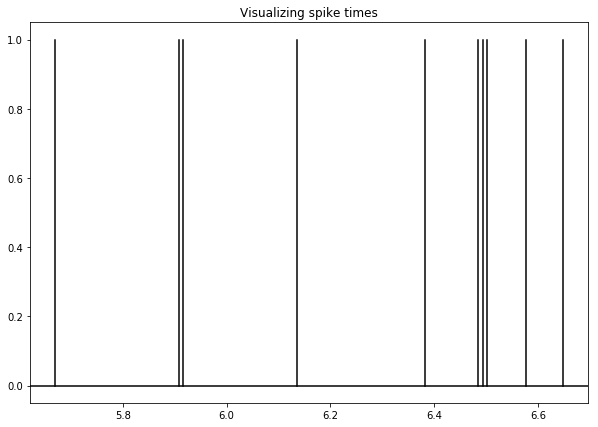

In [4]:
# load data
tmp = loadmat('CRE181_spikingData.mat');
data = tmp['data']

# this is how you access the first neuron -- the second is data[0][1], third is data[0][2], and so on
# what this gives you is an array of timestamps at which spikes occurred
spike_times = data[0][0]

# visualizing the spikes
plt.figure(figsize=(10,7))
for i in np.arange(10):
    plt.plot([spike_times[i],spike_times[i]],[0,1],'k')

plt.axhline(y=0, color='k')
plt.title('Visualizing spike times')
plt.show()
         

To compute the firing rate, then, we'll first need to define some new time bins to average the firing rate in a way that's more easily intepretable. I would suggest starting with time bins of width $250$ ms. Once those time bins are defined, you will need to count the number of spikes that occur in each bin, i.e. count the number of spike times that fall in each bin, and divide by the width of the bin to get the average firing rate:

$$
\text{firing_rate}(t) \approx \frac{\sum_t^{t+\Delta t} \text{spike_times}}{\Delta t}
$$

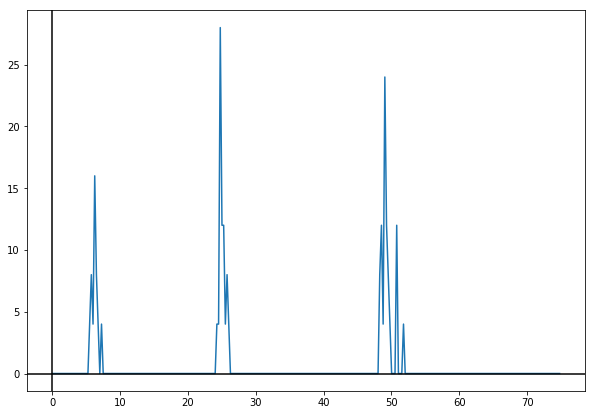

In [5]:
# get the spike times
spike_times = data[0][0]

# 1. define new time bins to average the data
dt = 0.25;
ts_bins = np.arange(ts[0],ts[-1],dt)

# 2. count the number of spikes in each bin
spike_counts,_ = np.histogram(spike_times,ts_bins)

# 3. divide by the time-width of the bin to compute the rate
spike_rates = spike_counts/np.diff(ts_bins)

# 4. plot the results
# it might be helpful to zoom into a subset of the session
plt.figure(figsize=(10,7))
plt.plot(ts_bins[:300],spike_rates[:300]);
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.show()

Oftentimes, looking at how the firing rate evolves over time isn't very informative. We want to know if the firing rate of the neuron changes with respect to some environmental variable to see if its tuned to anything in particular. The most relevant variable in this task (apart from the Froot Loops of course) is *position*, and dorsal hippocampus just so happens to be known for it's abundance of *place cells*. Place cells are neurons that like to fire in particular areas of the environment. We can figure out what place a neuron likes to fire by computing *rate maps*. This is a firing rate that's not only relative to time but also position.

To compute rate maps, we'll want the circular position, not the cumulative position, such that we can average the firing rate of the neuron over every time CRE181 visits a particular location on the circle track. To do this, we'll now want *position bins* to count up the spikes. This will require knowing the *position* at which each spike occurred. Finally, once we've counted up the number of spikes in each position bin, we'll need to divide each of these counts by the amount of time CRE181 spent in that position bin, known as the *occupancy* at that position:

$$
\text{rate_map}(x) = \frac{\sum_x^{x+\Delta x} \text{spike_positions}}{\text{occupancy}(x)} \\
\text{spike_positions} = \text{position corresponding to each spike time} \\
\text{occupancy}(x) = \text{total time spent at }x = \frac{\sum \text{samples at }x}{\text{sampling_rate}}
$$

Compute the rate map of the first neuron using position bins of width $3 cm$.

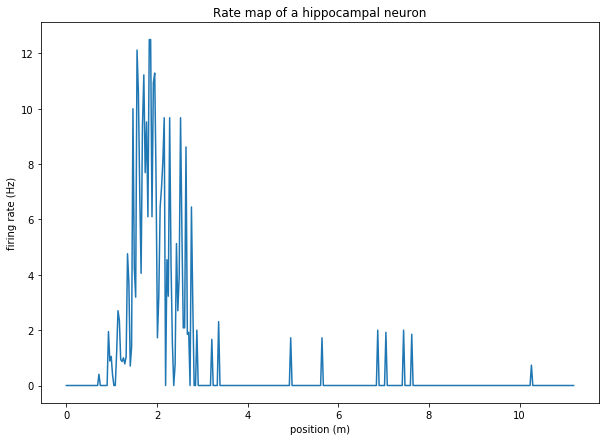

In [6]:
# if you haven't already, convert theta (NOT cumulative theta) into a measure of distance
pos = circumf * theta/(2*np.pi)

# 1. define position bins
dpos = 0.03 # three cm
pos_bins = np.arange(np.min(pos),np.max(pos),dpos)

# 2. get the positions at which the spikes occurred
# hint: a useful function to use is np.digitize
spike_inds = np.digitize(spike_times,ts)
spike_pos = pos[spike_inds]

# 3. count the number of spikes in each position bin
spike_counts,_ = np.histogram(spike_pos,pos_bins)

# 4. compute the occupancy for each position
n_samples,_ = np.histogram(pos,pos_bins)
t_sample = np.mean(np.diff(ts))
occupancy = t_sample * n_samples

# 5. compute the rate map
rate_map = spike_counts/occupancy

# 6. plot results
plt.figure(figsize=(10,7))
plt.plot(pos_bins[:-1],rate_map);
plt.xlabel('position (m)')
plt.ylabel('firing rate (Hz)')
plt.title('Rate map of a hippocampal neuron')
plt.show()


There are actually 20 neurons included in CRE181's dataset. Once you get you rate map working on the first one, you can repeat the process for the remaining neurons -- you can even plot them all together using ``plt.subplots``. 

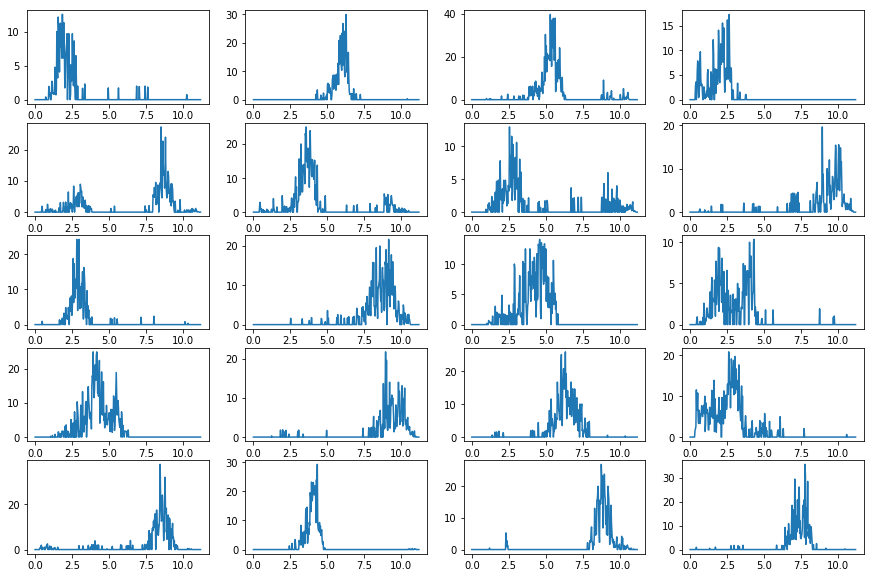

In [7]:
_,axs = plt.subplots(5,4,figsize=(15,10))
nrow = 0
ncol = 0

# for loop to plot
for i in np.arange(20):
    spike_times = data[0][i]
    
    # 2. get the positions at which the spikes occurred
    # hint: a useful function to use is np.digitize
    spike_inds = np.digitize(spike_times,ts)
    spike_pos = pos[spike_inds]

    # 3. count the number of spikes in each position bin
    spike_counts,_ = np.histogram(spike_pos,pos_bins)

    # 4. compute the occupancy for each position
    n_samples,_ = np.histogram(pos,pos_bins)
    t_sample = np.mean(np.diff(ts))
    occupancy = t_sample * n_samples

    # 5. compute the rate map
    rate_map = spike_counts/occupancy

    axs[nrow,ncol].plot(pos_bins[:-1],rate_map)
    
    if ncol < 3:
        ncol+=1
    else:
        nrow+=1
        ncol=0

Look at all of those place fields! Of course, position isn't the only variable we'll every want to look at for neural tuning. The more general general analysis to examing firing rates with respect to environmental variables is referred to as a **peristimulus time histogram** or PSTH. It is calculated in essentially the same way as a rate map, except instead of position bins, you define time bins that correspond to a specific stimulus or event.

**BONUS:** A cool way to visualize multiple rate maps together is to sort them in order of their peaks and plot them using a 2D heat map such as ``plt.pcolormesh``. See if you can do this! You'll see a cool result: that these place cells tile the environmentment and together form a spatial sequence.

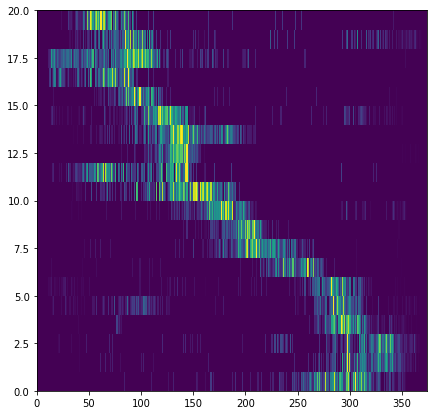

In [8]:
# for loop to plot
rate_maps = np.zeros((20,np.size(pos_bins)-1))

for i in np.arange(20):
    spike_times = data[0][i]
    
    # 2. get the positions at which the spikes occurred
    # hint: a useful function to use is np.digitize
    spike_inds = np.digitize(spike_times,ts)
    spike_pos = pos[spike_inds]

    # 3. count the number of spikes in each position bin
    spike_counts,_ = np.histogram(spike_pos,pos_bins)

    # 4. compute the occupancy for each position
    n_samples,_ = np.histogram(pos,pos_bins)
    t_sample = np.mean(np.diff(ts))
    occupancy = t_sample * n_samples

    # 5. compute the rate map
    rate_map = spike_counts/occupancy
    rate_maps[i,:] = rate_map/np.max(rate_map)

  
peaks = np.argmax(rate_maps,1) 
inds = np.argsort(-peaks)

plt.figure(figsize=(7,7))
plt.pcolormesh(rate_maps[inds,:])
plt.show()    